In [262]:
#load in packages
import seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import Levenshtein
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams.update({'font.size':20})

##Read in all study data from API

In [263]:
import urllib, json
url = "http://www.cbioportal.org/api/studies"
response = urllib.urlopen(url)
all_studies = json.loads(response.read())

##Choose random study to serve as a "new" study and print the attributes

In [314]:
studies=[]
study_attributes = []

#takes some time to download data via api
for study in all_studies:
    studyID = study['studyId']
    study_api_url = 'http://cbioportal.org/api/studies/' + studyID + '/clinical-attributes'
    df = pd.read_json(study_api_url)
    
    #make sure the study has data
    if not df.empty:
        studies.append((studyID ,df))
        study_attributes.append((studyID ,df['clinicalAttributeId'].tolist()))

In [279]:
study_names=[]
for study in study_attributes:
    study_names.append(study[0])

In [280]:
#split data into test studies
#choose test study
import random
test_study = random.choice(study_names)

In [281]:
test_study

u'stad_tcga_pub'

In [282]:
studies=[]
study_attributes = []

#takes some time to download data via api
for study in all_studies:
    studyID = study['studyId']
    study_api_url = 'http://cbioportal.org/api/studies/' + studyID + '/clinical-attributes'
    df = pd.read_json(study_api_url)
    
    #make sure the study has data
    if (not df.empty) and (studyID != test_study):
        studies.append((studyID ,df))
        study_attributes.append((studyID ,df['clinicalAttributeId'].tolist()))

In [270]:
study_names=[]
for study in study_attributes:
    study_names.append(study[0])

In [271]:
#transform data into boolean table of studies/attributes
#entries in the table are 1 if a study contains an attribute and 0 otherwise
study_attribute = []
for i in study_attributes:
    for j in i[1]:
        study_attribute.append((i[0],j))

study_attribute_pairs = pd.DataFrame.from_records(study_attribute, columns = ['study','attribute'])

study_data_nolabel = pd.get_dummies(study_attribute_pairs['attribute'])

study_data_combined = pd.concat([study_attribute_pairs['study'], study_data_nolabel], axis=1)
study_data_combined = study_data_combined.groupby('study').sum()


In [47]:
test_study_api_url = 'http://cbioportal.org/api/studies/' + test_study + '/clinical-attributes'
test_study_data = pd.read_json(test_study_api_url)
test_study_data['clinicalAttributeId']

0                         AGE
1     ANGIOLYMPHATIC_INVASION
2                 CANCER_TYPE
3        CANCER_TYPE_DETAILED
4                CLIN_M_STAGE
5                CLIN_N_STAGE
6                   ER_STATUS
7       EST_TUMOR_CELLULARITY
8                       GRADE
9           HISTOLOGICAL_TYPE
10                  IHC_BASAL
11                  IHC_CK5_6
12                   IHC_EGFR
13                   IHC_HER2
14              PAM50_SUBTYPE
15                  PR_STATUS
16                 TUMOR_SIZE
Name: clinicalAttributeId, dtype: object

In [96]:
exact_matching_attributes = np.intersect1d(test_study_data['clinicalAttributeId'].values, np.asarray(list(study_data_combined)))

In [112]:
non_matching_attributes = np.setdiff1d(test_study_data['clinicalAttributeId'].values, np.asarray(list(study_data_combined)))

##Find possible matching studies when no exact matches exist

In [113]:
#calculate the Levenshtein ratio for all pairs
all_col_names = list(study_data_combined)
#total_attributes = len(all_col_names)
lev_dist = np.zeros([len(all_col_names), len(non_matching_attributes)])
for i in range(len(all_col_names)):
    for j in range(len(non_matching_attributes)):
        lev_dist[i,j]=Levenshtein.ratio(all_col_names[i].upper(), non_matching_attributes[j].upper())

In [216]:
#find pairs of studies which might be a match (via levenshtein test)
#add check to see if attributes are part of the same study
test=pd.DataFrame(data=lev_dist.T,
index=non_matching_attributes, 
columns=all_col_names)
df_test = pd.DataFrame(data=list(test[test > 0.5].stack().index))

##Print possible matching attributes along with datatype

In [222]:
from collections import Counter
sample_or_patient = {True:"patient", False:"sample"}

print "================================================" 
print "attributes with exact matches:"
print "================================================"

for attribute in exact_matching_attributes:
    print attribute + " is present in " + str(int(study_data_combined.sum()[attribute])) + " other studies"

print ""
print "================================================"
print "attributes with possible matches:"
print "================================================"

no_matches = []
possible_match_count = 0
for attribute in non_matching_attributes:
    #print matching attributes
    #filtered_matches = np.intersect1d(df_test[df_test[0]==attribute][1].values, np.asarray(list(study_data_combined))[(study_data_combined.loc[msk, :].sum()==0).values])
    filtered_matches = np.setdiff1d(df_test[df_test[0]==attribute][1].values, exact_matching_attributes)
    if (filtered_matches.size)>0:
        possible_match_count += 1
        #print attribute in new study along with datatype and patient/sample attribute
        print "================================================"
        print "new study attribute: " + attribute
        print "datatype: " + test_study_data[test_study_data['clinicalAttributeId']==attribute]['datatype'].values[0]
        print "patient attribute?: " + str(test_study_data[test_study_data['clinicalAttributeId']==attribute]['patientAttribute'].values[0])
        print '---------------------------------------'
        #print similar attributes found in existing studies along with the datatype
        print 'possible matches:'
            
        for matching_attribute in filtered_matches:
            #make sure match isn't an attribute in the new study
            #filtered_matches = np.setdiff1d(df_test[df_test[0]==attribute][1].values, exact_matching_attributes)
            #if filtered_matches.size>0:
            print matching_attribute + ", which is present in " + str(int(study_data_combined.sum()[matching_attribute])) + " other studies"
            studies_with_attribute=study_data_combined[study_data_combined[matching_attribute]>0].index    
            attribute_dtypes=[]
            attribute_ps_types=[]
            for study in studies_with_attribute:
                study_index=study_names.index(study)

                attribute_data=studies[study_index][1]
                attribute_dtype=attribute_data[attribute_data['clinicalAttributeId']==matching_attribute]['datatype']
                attribute_dtypes.append(attribute_dtype.get_values()[0])

                attribute_ps_type=attribute_data[attribute_data['clinicalAttributeId']==matching_attribute]['patientAttribute']
                attribute_ps_types.append(sample_or_patient[attribute_ps_type.get_values()[0]])

            print Counter(attribute_dtypes)
            print Counter(attribute_ps_types)
    else:
        no_matches.append(attribute)

if possible_match_count == 0:
    print "No similar matches detected."
    
print ""
print "================================================" 
print "attributes with NO matches:"
print "================================================"

for attribute in no_matches:
    print attribute

attributes with exact matches:
AGE is present in 121 other studies
ANGIOLYMPHATIC_INVASION is present in 3 other studies
CANCER_TYPE is present in 146 other studies
CANCER_TYPE_DETAILED is present in 147 other studies
CLIN_M_STAGE is present in 13 other studies
CLIN_N_STAGE is present in 8 other studies
ER_STATUS is present in 4 other studies
EST_TUMOR_CELLULARITY is present in 1 other studies
GRADE is present in 30 other studies
HISTOLOGICAL_TYPE is present in 2 other studies
IHC_HER2 is present in 4 other studies
PAM50_SUBTYPE is present in 1 other studies
PR_STATUS is present in 4 other studies
TUMOR_SIZE is present in 6 other studies

attributes with possible matches:
new study attribute: IHC_BASAL
datatype: STRING
patient attribute?: False
---------------------------------------
possible matches:
IDH_STATUS, which is present in 1 other studies
Counter({u'STRING': 1})
Counter({'sample': 1})
IHC_SCORE, which is present in 2 other studies
Counter({u'NUMBER': 2})
Counter({'sample': 1,

##Number of attributes in each study

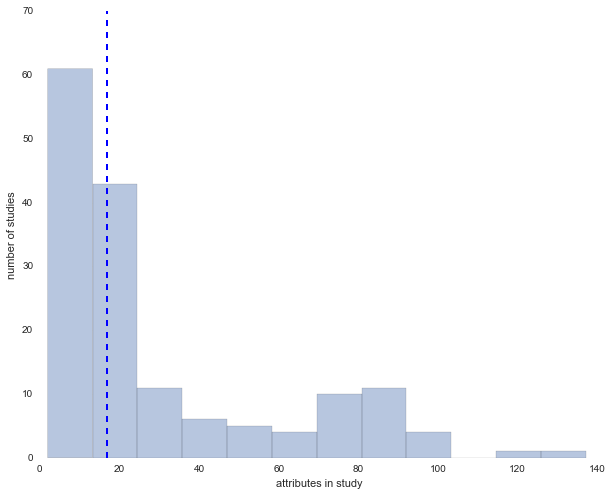

In [157]:
ax=seaborn.distplot(study_data_combined.sum(axis=1), kde=False)
ax.set(ylabel='number of studies', xlabel='attributes in study')
plt.axvline(test_study_data['clinicalAttributeId'].size, color='b', linestyle='dashed', linewidth=2)
plt.show()

##Number of unique attributes in each study

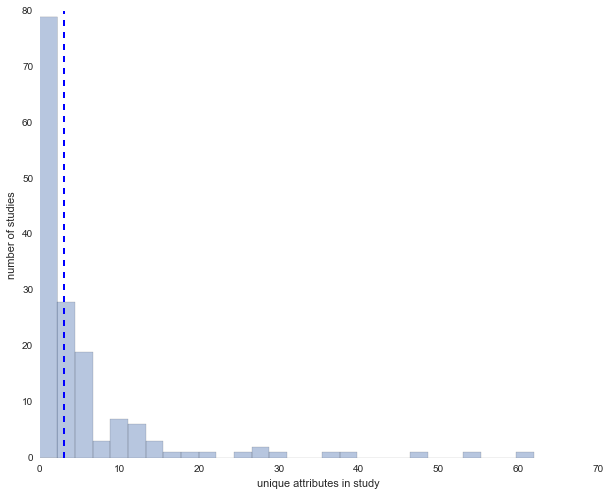

In [315]:
unique_attributes_cBio_studies = study_data_combined.T[(study_data_combined.sum(axis=0)==1).values].sum(axis=0)
ax=seaborn.distplot(unique_attributes_cBio_studies, kde=False)
ax.set(ylabel='number of studies', xlabel='unique attributes in study')
plt.axvline(non_matching_attributes.size, color='b', linestyle='dashed', linewidth=2)
plt.show()

##Number of common attributes in each study

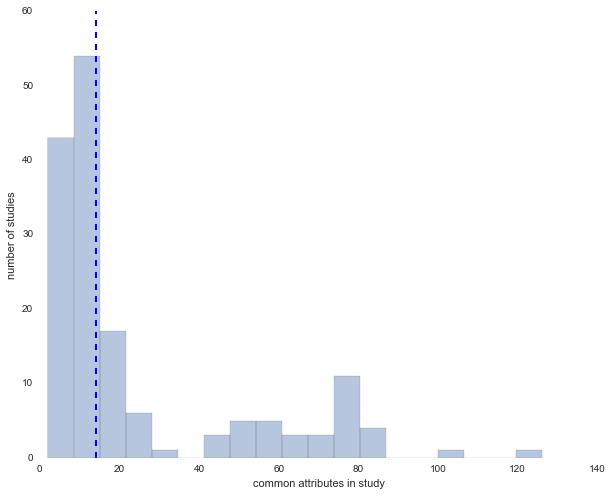

In [316]:
common_attributes = study_data_combined.sum(axis=1) - unique_attributes_cBio_studies
ax=seaborn.distplot(common_attributes, kde=False)
ax.set(ylabel='number of studies', xlabel='common attributes in study')
plt.axvline(exact_matching_attributes.size, color='b', linestyle='dashed', linewidth=2)
plt.show()

In [407]:
attribute_data = []
for study in studies_clinical_data:
    study_data_attributes = list(study[1])
    
    #get attribute data to filter based on datatype
    study_api_url = 'http://cbioportal.org/api/studies/' + study[0] + '/clinical-attributes'
    df = pd.read_json(study_api_url)
    for attribute in study_data_attributes:
        if attribute != (u'OTHER_SAMPLE_ID' or u'OTHER_PATIENT_ID'):
            if df['datatype'][df['clinicalAttributeId']==attribute].values[0] == 'STRING':
                data = set(study[1][attribute])
                for d in data:
                    if not is_number(d):
                        attribute_data.append((attribute.upper(), d.upper()))
        
attribute_data_pairs = pd.DataFrame.from_records(attribute_data, columns = ['attribute','data'])

attribute_data_nolabel = pd.get_dummies(attribute_data_pairs['data'])

attribute_data_combined = pd.concat([attribute_data_pairs['attribute'], attribute_data_nolabel], axis=1)
attribute_data_combined = attribute_data_combined.groupby('attribute').sum()

#drop values which only occur in single attribute
attribute_data_combined.drop([col for col, val in attribute_data_combined.sum().iteritems() if val < 5], axis=1, inplace=True)

In [408]:
attribute_data_combined.shape

(500, 122)

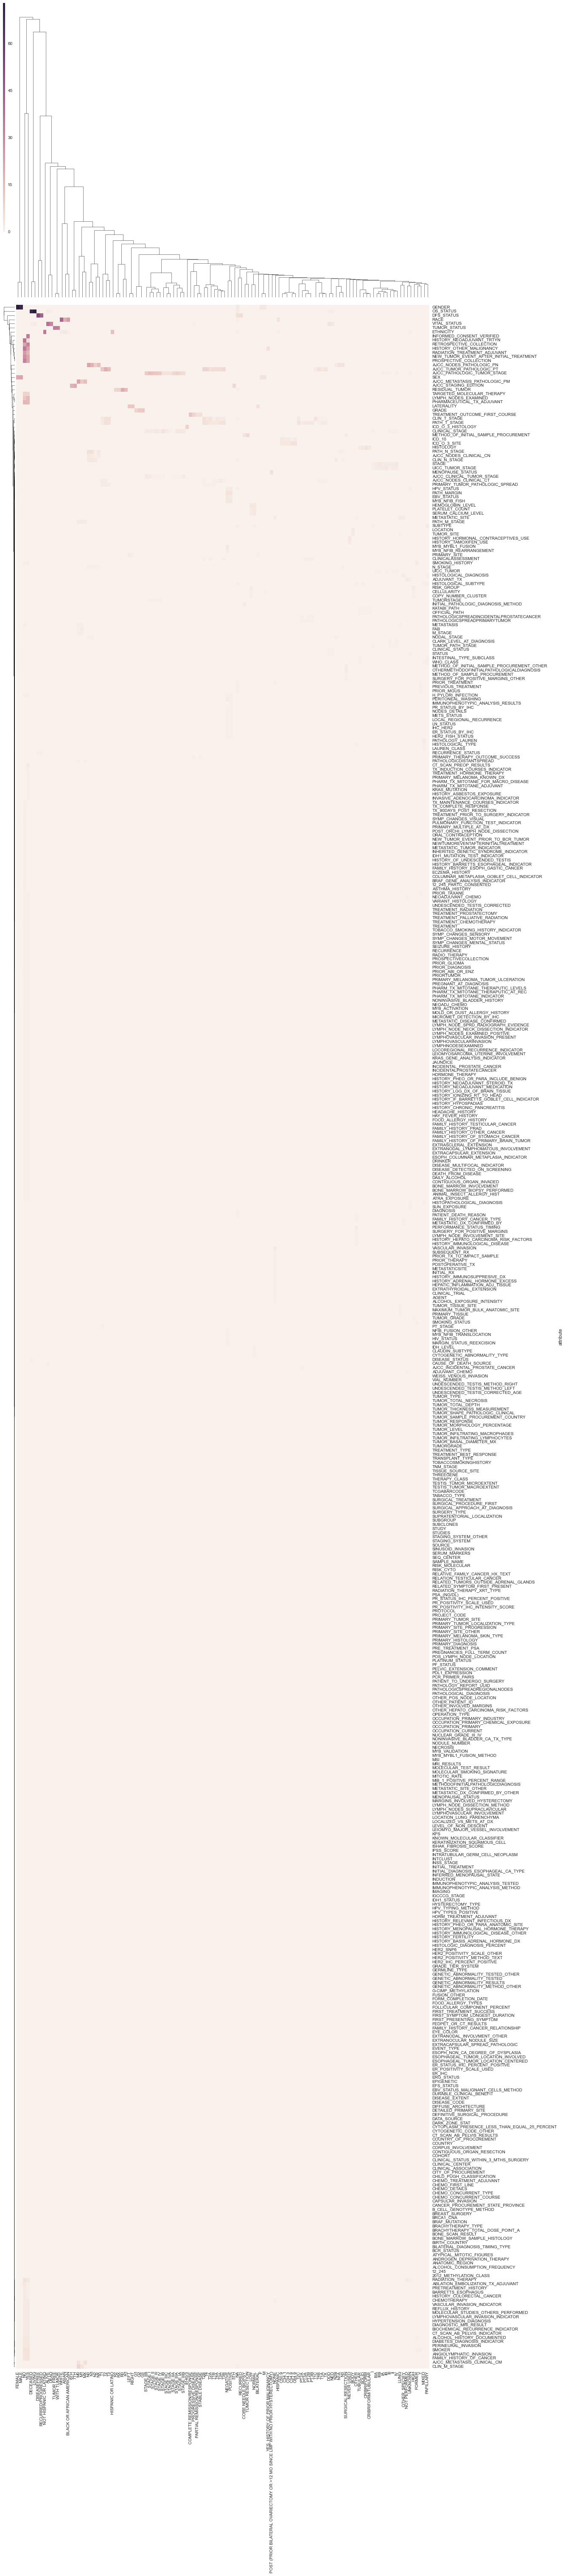

In [421]:
seaborn.clustermap(attribute_data_combined, method='average', metric='euclidean', figsize=(18, 100))